In [ ]:
%load_ext load_style
%load_style talk.css

# PCA of SST anomalies in the Pacific with scikit-learn

In [3]:
import pandas as pd
import numpy as np
from numpy import ma
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

In [4]:
%matplotlib inline

## load the SST data

In [5]:
import xray

In [6]:
dset = xray.open_dataset('../data/ersst.realtime.nc')

In [7]:
dset

<xray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 806, zlev: 1)
Coordinates:
  * time     (time) datetime64[ns] 1948-02-15 1948-03-15 1948-04-15 1948-05-15 1948-06-15 ...
  * zlev     (zlev) float32 0.0
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 -72.0 -70.0 -68.0 ...
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 26.0 28.0 ...
Data variables:
    sst      (time, zlev, lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan nan nan ...
    anom     (time, zlev, lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan nan nan ...
    err      (time, zlev, lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    title: ERSST V3b in situ only
    history: Wed Apr  8 09:45:04 2015: /usr/local/bin/ncrcat -O ersst.194802_ft.nc ersst.194803_ft.nc ersst.194804_ft.nc ersst.194805_ft.nc ersst.194806_ft.nc ersst.194807_ft.nc ersst.194808_ft.nc ersst.194809_ft.nc ersst.194810_ft.n

### selects the period 1980 - 2014 and the tropical Pacific domain

In [10]:
dsub = dset.sel(time=slice('1980','2014'), zlev=0, lat=slice(-40,40), lon=slice(120,290))

In [11]:
lat = dsub['lat'].values
lon = dsub['lon'].values
sst = dsub['anom'].values

In [12]:
sst.shape

(420, 41, 86)

### reshape in 2D (time, space)

In [13]:
X = np.reshape(sst, (sst.shape[0], len(lat) * len(lon)), order='F')

In [19]:
np.any(np.isnan(X))

True

### Mask the land points

In [20]:
type(X)

numpy.ndarray

In [21]:
X = ma.masked_array(X, np.isnan(X))

In [22]:
type(X)

numpy.ma.core.MaskedArray

In [23]:
land = X.sum(0).mask

In [24]:
ocean = -land

### keep only oceanic grid-points

In [25]:
X = X[:,ocean]

### Standardize SST using the fit and transform methods of the `sklearn.preprocessing.scaler.StandardScaler`

In [30]:
from sklearn import preprocessing
scaler  = preprocessing.StandardScaler()

In [31]:
scaler_sst = scaler.fit(X)

### Once the scaler object has been 'trained' on the data, we can save it as a pickle object

In [32]:
from sklearn.externals import joblib

In [33]:
joblib.dump(scaler_sst, '../data/scaler_sst.pkl', compress=9)

['../data/scaler_sst.pkl']

In [34]:
scaler_sst = joblib.load('../data/scaler_sst.pkl')

### scales: use the `transform` method of the scaler object

In [35]:
X = scaler_sst.transform(X)

### verify that mean = 0 and std = 1

In [36]:
X.mean()

1.0151690477930695e-18

In [37]:
X.std()

0.99999999999999967

In [38]:
X.shape

(420, 3133)

### EOF decomposition 

In [39]:
from sklearn.decomposition import pca

#### instantiates the PCA object

In [40]:
skpca = pca.PCA()

#### fit

In [41]:
skpca.fit(X)

PCA(copy=True, n_components=None, whiten=False)

In [ ]:
skpca.

### Now saves the (fitted) PCA object for reuse in operations

In [43]:
joblib.dump(skpca, '../data/EOF.pkl', compress=9)

['../data/EOF.pkl']

In [44]:
from matplotlib import style
style.use('fivethirtyeight')

In [45]:
style.available

[u'dark_background', u'bmh', u'grayscale', u'ggplot', u'fivethirtyeight']

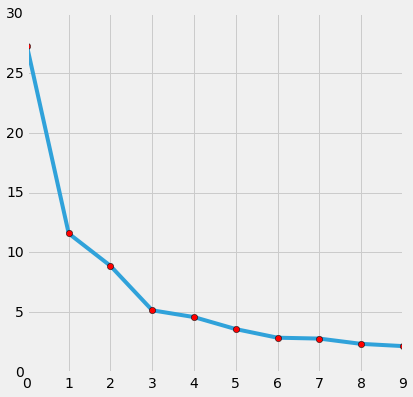

In [46]:
f, ax = plt.subplots(figsize=(6,6))
ax.plot(skpca.explained_variance_ratio_[0:10]*100)
ax.plot(skpca.explained_variance_ratio_[0:10]*100,'ro')

### keep number of PC sufficient to explain 70 % of the original variance 

In [47]:
ipc = np.where(skpca.explained_variance_ratio_.cumsum() >= 0.70)[0][0]

In [48]:
ipc

9

### The Principal Components (PCs) are obtained by using the `transform` method of the `pca` object (`skpca`)

In [49]:
PCs = skpca.transform(X)

In [50]:
PCs = PCs[:,:ipc]

### The Empirical Orthogonal Functions (EOFs) are contained in the `components_` attribute of the `pca` object (`skpca`)

In [51]:
EOFs = skpca.components_

In [52]:
EOFs = EOFs[:ipc,:]

In [53]:
EOFs.shape

(9, 3133)

### we can the reconstruct the 2D fields (maps)

In [54]:
EOF_recons = np.ones((ipc, len(lat) * len(lon))) * -999.

In [55]:
for i in xrange(ipc): 
    EOF_recons[i,ocean] = EOFs[i,:]

In [56]:
EOF_recons = ma.masked_values(np.reshape(EOF_recons, (ipc, len(lat), len(lon)), order='F'), -999.)

In [57]:
EOF_recons.shape

(9, 41, 86)

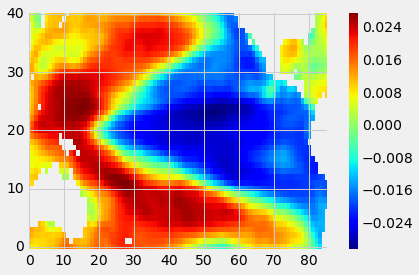

In [58]:
plt.imshow(EOF_recons[0,:,:], origin='lower', interpolation='nearest', aspect='auto')
plt.colorbar();

### scale the Principal Components

In [59]:
from sklearn.preprocessing import StandardScaler

In [60]:
scaler_PCs = StandardScaler()

In [61]:
scaler_PCs.fit(PCs)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [62]:
PCs_std = scaler_PCs.transform(PCs)

In [ ]:
joblib.dump(scaler_PCs, '../outputs/scaler_PCs.pkl')

In [63]:
PCdf = pd.DataFrame(PCs_std, index = dsub['time'], \
                    columns = ["EOF%s" % (x) for x in xrange(1, PCs_std.shape[1] +1)])

In [64]:
PCdf.head()

,EOF1,EOF2,EOF3,EOF4,EOF5,EOF6,EOF7,EOF8,EOF9
time,,,,,,,,,
1980-01-15,-1.212233,-0.494918,0.972392,0.281485,-0.203608,2.072378,-0.632693,1.473872,-1.271845
1980-02-15,-1.213163,-0.715776,1.258066,0.741005,0.068926,2.731611,-0.182779,2.636705,-1.737925
1980-03-15,-0.898226,-0.562729,0.855915,1.316607,0.514087,2.650314,-0.001962,1.904691,-0.073639
1980-04-15,-1.037391,-1.086395,0.485100,0.374338,0.952949,1.320651,-0.340679,1.921813,0.549309
1980-05-15,-1.010956,-1.156914,0.006662,0.309884,0.534675,0.655073,-0.508158,1.677837,-0.253518


In [67]:
PCdf.to_csv('../data/EOF_ERSST_PCs.csv')

In [65]:
from scipy.signal import detrend

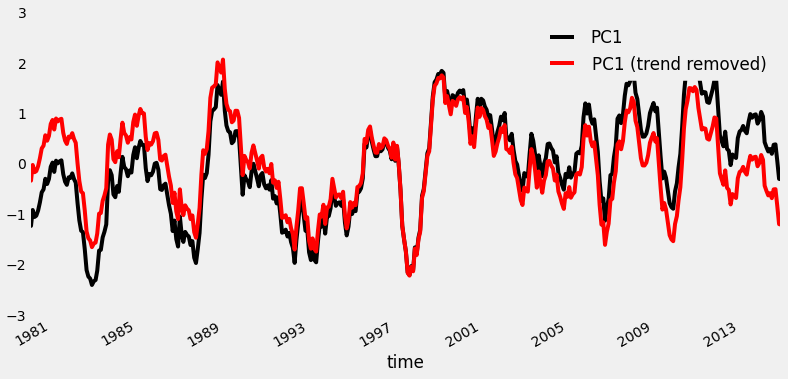

In [66]:
f, ax = plt.subplots(figsize=(12,6))
PCdf.ix[:,0].plot(ax=ax, color='k', label='PC1')
#ax.set_xlabel('period', fontsize=18)
ax.plot(PCdf.index, detrend(PCdf.ix[:,0].values), 'r',  label='PC1 (trend removed)')
ax.grid('off')
ax.legend(loc=1); 